In [1]:
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
import pandas as pd
import seaborn as sns
import pennylane as qml
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input
from keras.optimizers import Adam
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.regularizers import l2
from imblearn.over_sampling import SMOTE
from qiskit.algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler                             
from qiskit_machine_learning.algorithms.classifiers import VQC 
from IPython.display import clear_output
import matplotlib.pyplot as plt
import time, copy, warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

data = pd.read_csv('C:/Users/RDSC/downloads/FLC_labeled_notime.csv', sep=';')


# Display the first few rows of the dataset to understand its structure
print(data.head())






   open  high   low  close    Volume   Volume MA  manipulated
0  4700  4700  4580   4600  15576400  12083646.0            0
1  4520  4600  4480   4490  18797400  12559327.5            0
2  4500  4530  4380   4390  22116400  13069294.0            0
3  4380  4550  4380   4430  13101500  13310592.0            0
4  4480  4550  4430   4440  12386000  13530883.5            0


In [2]:
# Convert the data into a DataFrame
df = pd.DataFrame(data)

# Step 2: Explore the dimensions
print("Number of rows and columns:", df.shape)

Number of rows and columns: (329, 7)


In [3]:
# Convert the data into a DataFrame
df = pd.DataFrame(data)

# Step 1: Handling Missing Values (if any)
# Check for missing values in the DataFrame
print(df.isnull().sum())



open           0
high           0
low            0
close          0
Volume         0
Volume MA      0
manipulated    0
dtype: int64


## Outliers

In [4]:
#If there are any missing values, you can impute them with the mean, median, or mode.
# For example, to impute missing values with the mean:
df.fillna(df.mean(), inplace=True)

# Specify the column for which you want to check outliers
column_name = 'manipulated'  

# Calculate the mean and standard deviation of the column
mean = df[column_name].mean()
std = df[column_name].std()

# Define the threshold for identifying outliers (e.g., z-score > 3)
threshold = 3

# Initialize a list to store outliers
outliers = []

# Calculate the z-score for each value in the column and identify outliers
for index, value in df[column_name].iteritems():
    z_score = (value - mean) / std
    if z_score > threshold:
        outliers.append(value)

print('Outliers in the dataset:', outliers)

Outliers in the dataset: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [5]:
nonfraud_count = data[data.manipulated == 0]
fraud_count = data[data.manipulated == 1]


num_normal = nonfraud_count.shape[0] 
num_fraud = fraud_count.shape[0] 

print(f"Number of normal examples = {num_normal}")
print(f"Number of fraud examples = {num_fraud}\n")


ratio = num_normal/num_fraud
print(f'normal to fraud ratio in the whole data = {round(ratio,2)}')

Number of normal examples = 301
Number of fraud examples = 28

normal to fraud ratio in the whole data = 10.75


## Oversampling

In [6]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE


# Instantiate the SMOTE object
smote = SMOTE(sampling_strategy='auto')

# Resample the data using SMOTE
X_resampled, y_resampled = smote.fit_resample(pd.concat([nonfraud_count, fraud_count], axis=0).iloc[:, :-1], 
                                              pd.concat([nonfraud_count, fraud_count], axis=0).iloc[:, -1])

# Combine the resampled data with the original fraud cases to create the final oversampled dataset
oversampled_data = pd.concat([pd.DataFrame(X_resampled), pd.Series(y_resampled, name='manipulated')], axis=1)

# Shuffle the data
oversampled_data = oversampled_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Feature scaling (if needed)
X = oversampled_data.iloc[:, :-1].values
X = MinMaxScaler().fit_transform(X)

# The target labels 'y' can be obtained from the last column
y = oversampled_data.iloc[:, -1].values

# Print the number of examples and features
num_examples, num_features = X.shape
print("Number of examples = ", num_examples)
print("Number of features = ", num_features)

# Print the first three examples
print(oversampled_data.head(10))


Number of examples =  602
Number of features =  6
    open   high    low  close    Volume     Volume MA  manipulated
0  13500  14700  13450  14700  50669900  2.761798e+07            0
1  17483  18083  17157  17975  21938156  2.457838e+07            1
2  18246  18544  17644  18082  17712914  2.389480e+07            1
3  11200  11500  10650  11050  30480200  3.433716e+07            0
4  10750  10900  10500  10800  14144600  1.669834e+07            0
5  10600  10850  10100  10450  15099100  2.593997e+07            0
6   5500   5540   5450   5540  22645300  1.803185e+07            0
7  15612  16107  15188  15838  23101840  2.651915e+07            1
8  10500  10800  10300  10450  37416000  3.423918e+07            0
9  17171  18247  16971  18135  26531544  2.422690e+07            1


In [7]:
''' 
Zero padding is to make the number of features equal to a power of 2.
it is required for 'amplitude encoding' given below.
'''

n = int(np.ceil(np.log2(num_features)))
dim = 2**n
print(f'(number of qubits, dimension of the Hilbert space) = {(n, dim)}')

zeros = np.zeros((num_examples, dim-num_features))
X = np.append(X, zeros, axis=1)
num_examples, num_features = X.shape

num_examples, num_features = X.shape   
print("number of examples = ", num_examples)
print("number of features = ", num_features)

(number of qubits, dimension of the Hilbert space) = (3, 8)
number of examples =  602
number of features =  8


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print(X_train.shape, X_test.shape ,  y_train.shape, y_test.shape)

(421, 8) (181, 8) (421,) (181,)


## Model Building

In [9]:
from qiskit_machine_learning.circuit.library import RawFeatureVector


fm = RawFeatureVector(feature_dimension=num_features) 
fm.draw() 

┌───────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                                  ├
     │                                                                   │
q_1: ┤1 Parameterizedinitialize(x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7]) ├
     │                                                                   │
q_2: ┤2                                                                  ├
     └───────────────────────────────────────────────────────────────────┘

In [10]:
from qiskit.circuit.library import RealAmplitudes


'''
For amplitude encoding, num_qubits = n = np.log2(num_features)
'''

pqc = RealAmplitudes(num_qubits=n, reps= 4)
pqc.decompose().draw()

┌──────────┐                 ┌──────────┐                 ┌──────────┐»
q_0: ┤ Ry(θ[0]) ├──────────■──────┤ Ry(θ[3]) ├──────────■──────┤ Ry(θ[6]) ├»
     ├──────────┤        ┌─┴─┐    ├──────────┤        ┌─┴─┐    ├──────────┤»
q_1: ┤ Ry(θ[1]) ├──■─────┤ X ├────┤ Ry(θ[4]) ├──■─────┤ X ├────┤ Ry(θ[7]) ├»
     ├──────────┤┌─┴─┐┌──┴───┴───┐└──────────┘┌─┴─┐┌──┴───┴───┐└──────────┘»
q_2: ┤ Ry(θ[2]) ├┤ X ├┤ Ry(θ[5]) ├────────────┤ X ├┤ Ry(θ[8]) ├────────────»
     └──────────┘└───┘└──────────┘            └───┘└──────────┘            »
«                        ┌──────────┐                  ┌───────────┐
«q_0: ───────────■───────┤ Ry(θ[9]) ├───────────■──────┤ Ry(θ[12]) ├
«              ┌─┴─┐    ┌┴──────────┤         ┌─┴─┐    ├───────────┤
«q_1: ──■──────┤ X ├────┤ Ry(θ[10]) ├──■──────┤ X ├────┤ Ry(θ[13]) ├
«     ┌─┴─┐┌───┴───┴───┐└───────────┘┌─┴─┐┌───┴───┴───┐└───────────┘
«q_2: ┤ X ├┤ Ry(θ[11]) ├─────────────┤ X ├┤ Ry(θ[14]) ├─────────────
«     └───┘└───────────┘             └───┘└───────────┘

In [11]:
optimizer = COBYLA(maxiter=150)                 
sampler = Sampler()




objective_func_vals = []
                                    
def callback(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()


vqc = VQC(
    sampler=sampler,
    feature_map=fm,
    ansatz=pqc,
    optimizer=optimizer,
    callback=callback,
)

## Training and evaluating performance

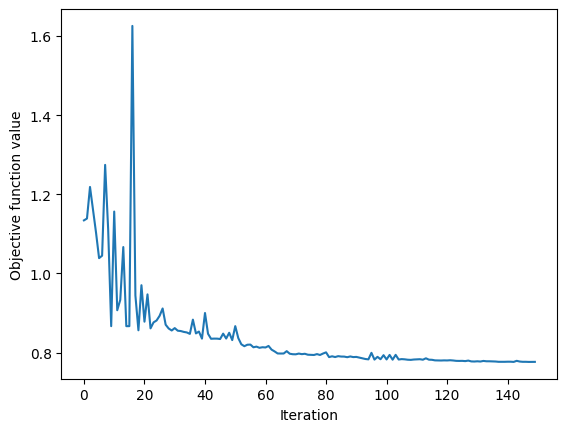

Wall time: 13min 10s


In [12]:
%%time

vqc.fit(X_train, y_train)

In [13]:
y_test_pred = vqc.predict(X_test)


print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred), "= confusion matrix for test set \n ")


              precision    recall  f1-score   support

           0       1.00      0.62      0.77        95
           1       0.70      1.00      0.83        86

    accuracy                           0.80       181
   macro avg       0.85      0.81      0.80       181
weighted avg       0.86      0.80      0.80       181

[[59 36]
 [ 0 86]] = confusion matrix for test set 
 


In [14]:
print(y_test_pred)

[0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 0 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1 0 0 1
 1 1 1 1 1 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 0 1 0 1
 1 0 1 1 0 1 1 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 1 1 0 0 1 1 1 0 1 1 0 0
 1 1 0 1 1 1 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 0 1 0 1 0 1]


In [15]:
print(y_test)

[0 0 0 1 1 0 0 0 0 1 1 1 0 1 1 0 0 1 1 0 0 1 1 1 0 1 0 1 1 1 1 0 0 0 1 1 1
 0 1 0 1 1 0 1 0 0 0 1 0 1 0 1 1 1 1 1 1 0 0 0 1 0 1 1 1 0 0 0 1 1 1 0 0 1
 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 1
 1 0 0 1 0 1 0 1 1 0 1 0 0 1 0 1 1 0 1 0 0 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 0
 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 0 1 0 1 0 0 0 0]
